# PS reconstruction, Gaussian beam

In [1]:
import torch
from copy import deepcopy

import lightning as L
from cheetah import Quadrupole, Drift, Screen

from gpsr.datasets import SixDReconstructionDataset
from gpsr.modeling import GPSR6DLattice, GPSR
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
p0c = 43.36e6  # reference momentum in eV/c

gt_beam = torch.load("../example_data/example_distributions/gaussian_beam.pt", weights_only=False)

## Define diagnostics lattice parameters

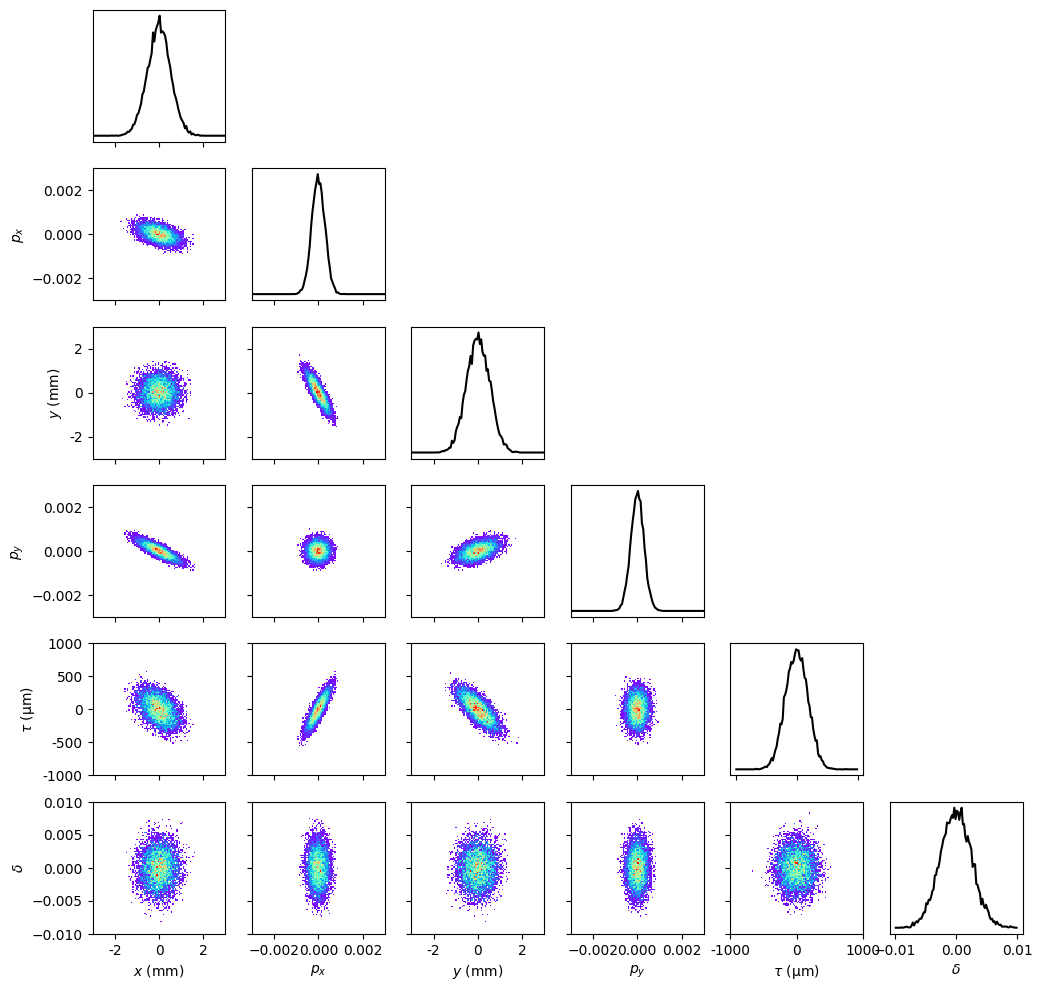

In [3]:
lims = [
    [-3e-3, 3e-3],
    [-3e-3, 3e-3],
    [-3e-3, 3e-3],
    [-3e-3, 3e-3],
    [-1e-3, 1e-3],
    [-1e-2, 1e-2],
]
gt_beam.plot_distribution(bin_ranges=lims);

Cheetah based version

In [4]:
# define upstream beamline
k1 = torch.tensor(-24.868402)
k2 = torch.tensor(26.179029)
k3 = torch.tensor(-26.782126)

quad_length = torch.tensor(0.11)
lq12 = torch.tensor(1.209548)
lq23 = torch.tensor(0.19685)
lq34 = torch.tensor(0.18415)
ld1 = lq12 - quad_length
ld2 = lq23 - quad_length
ld3 = lq34 - quad_length
q1 = Quadrupole(length=quad_length, k1=k1, num_steps=5, tracking_method="bmadx")
d1 = Drift(ld1)
q2 = Quadrupole(length=quad_length, k1=k2, num_steps=5, tracking_method="bmadx")
d2 = Drift(ld2)
q3 = Quadrupole(length=quad_length, k1=k3, num_steps=5, tracking_method="bmadx")
d3 = Drift(ld3)
upstream_components = [q1, d1, q2, d2, q3, d3]


screen = Screen(
    resolution=(200, 200),
    pixel_size=torch.ones(2) * 50e-6,
    is_active=True,
    kde_bandwidth=torch.tensor(25e-6),
    method="kde",
)

l_quad = 0.11
l_tdc = 0.01
f_tdc = 1.3e9
phi_tdc = 0.0
l_bend = 0.3018
theta_on = -20.0 * 3.14 / 180.0
l1 = 0.790702
l2 = 0.631698
l3 = 0.889


gpsr_lattice = GPSR6DLattice(
    l_quad,
    l_tdc,
    f_tdc,
    phi_tdc,
    l_bend,
    theta_on,
    l1,
    l2,
    l3,
    deepcopy(screen),
    deepcopy(screen),
    upstream_components,
)

In [5]:
# Scan over quad strength, tdc on/off and dipole on/off
n_ks = 5

PI = 3.14
gs = torch.tensor([-2.22e-16, -20.0 * PI / 180.0 / 0.365])  # dipole off/on
ks = torch.linspace(-3, 3, n_ks)  # quad ks
vs = torch.tensor([0, 3e6])  # TDC off/on

train_params = torch.meshgrid(ks, vs, gs, indexing="ij")
train_params = torch.stack(train_params, dim=-1)

print(train_params[0, 0, 0])

gpsr_lattice.set_lattice_parameters(train_params)
gt_observations = gpsr_lattice.track_and_observe(gt_beam)
gt_final_beam = gpsr_lattice.segment(gt_beam)
gt_final_beam.sigma_p.shape

tensor([-3.0000e+00,  0.0000e+00, -2.2200e-16])


torch.Size([5, 2, 2])

In [6]:
gt_observations[0].shape

torch.Size([5, 2, 200, 200])

In [7]:
obs_dataset = SixDReconstructionDataset(
    train_params, 
    gt_observations, 
    (gpsr_lattice.screen_1, gpsr_lattice.screen_2),
)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=5)

In [8]:
torch.save(obs_dataset, "../example_data/example_datasets/reconstruction_6D.dset")

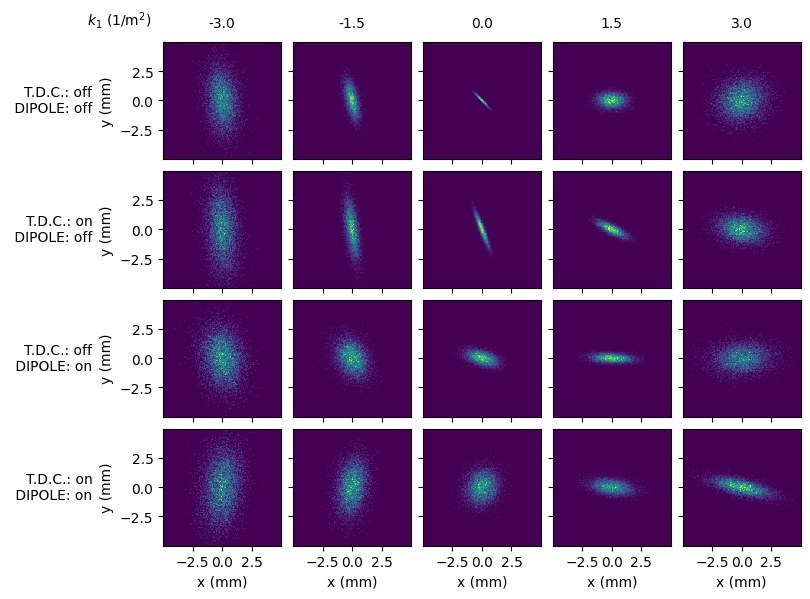

In [9]:
fig, ax = obs_dataset.plot_data(publication_size=True)

## Training using pytorch lightning

In [10]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(limit_train_batches=100, max_epochs=500, logger=logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model=litgpsr, train_dataloaders=train_loader)


  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode
/Users/pablo/miniforge3/envs/csr-psr/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/pablo/miniforge3/envs/csr-psr/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s, v_num=0]


In [12]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

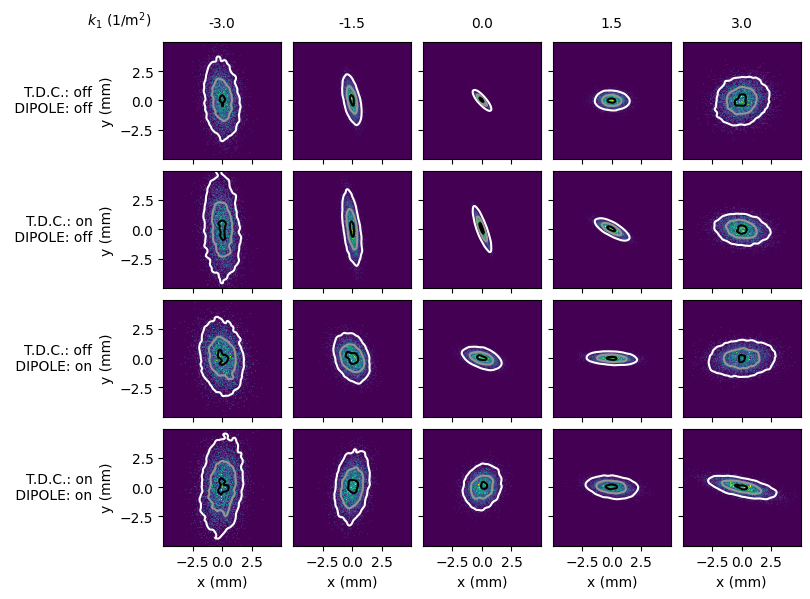

In [ ]:
pred = tuple([ele.detach() for ele in gpsr_model(train_params)])
pred_dataset = SixDReconstructionDataset(
    train_params, 
    pred, 
    (gpsr_lattice.screen_1, gpsr_lattice.screen_2)
)
obs_dataset.plot_data(
    overlay_data=pred_dataset,
    publication_size=True,
);

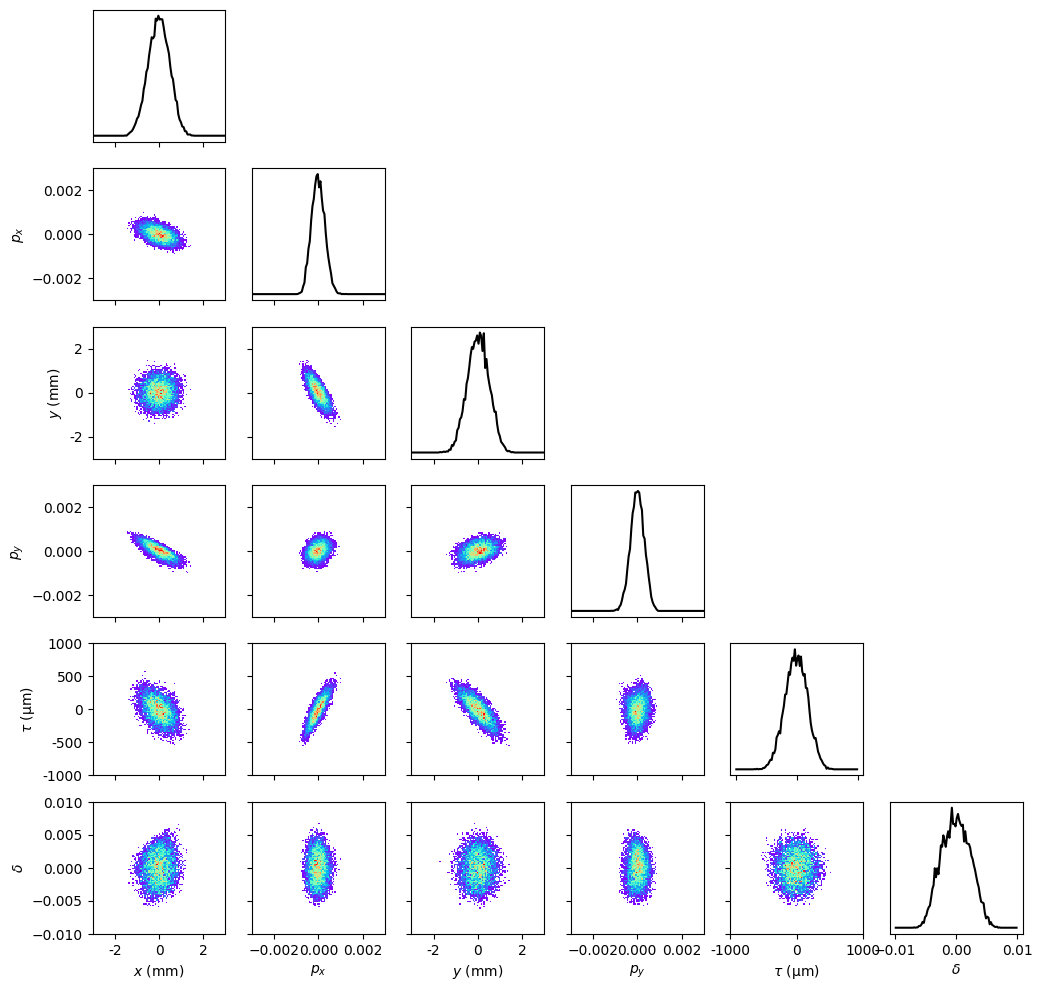

In [16]:
reconstructed_beam.plot_distribution(bin_ranges=lims);